In [69]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from utils import *

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sentence_transformers import SentenceTransformer, InputExample
from sklearn.manifold import TSNE

device = 'cuda'
# model_id = "sentence-transformers/all-MiniLM-L6-v2"
model_id = "model/robertaNLI_R2_soft_soft/"
model = SentenceTransformer(model_id).to(device)
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

In [3]:
data = pd.read_csv('data/preprocessed/chaos_train.csv')[['uid', 'label_dist', 'majority_label', 'entropy', 'premise', 'hypothesis']]
data['label_dist'] = data.apply(lambda x: [float(y) for y in string_of_list_to_list(x['label_dist'])], axis=1)
data.head()

,uid,label_dist,majority_label,entropy,premise,hypothesis
0,111680e,"[0.91, 0.07, 0.02]",e,0.505248,He dismounted and Ca'daan saw he was smaller t...,He was shorter than the others.
1,8221794333.jpg#0r1n,"[0.22, 0.64, 0.14]",n,1.289752,A young boy in a Cookie Monster t-shirt sits o...,A young boy is playing in a pile of leaves.
2,4637931300.jpg#2r1n,"[0.0, 0.9, 0.1]",n,0.468996,A man in an orange construction vest walks in ...,The child has no legs.
3,36715n,"[0.02, 0.8, 0.18]",n,0.815727,Jon twisted the man's wrist.,Jon grabbed the man and yelled at him.
4,4116163419.jpg#0r2n,"[0.02, 0.9500000000000001, 0.03]",n,0.334944,A man wearing a suit with a name tag stands re...,"A man with a name tag that reads ""Ben"" is stan..."


In [77]:
ps = list(data['premise'])
hs = list(data['hypothesis'])
p_embedding = model.encode(sentences = ps, show_progress_bar=True, convert_to_numpy=True)
h_embedding = model.encode(sentences = hs, show_progress_bar=True, convert_to_numpy=True)
diff = p_embedding - h_embedding
diff = normalize(diff, axis=1)
embed_concat = np.concatenate((p_embedding, h_embedding, np.abs(p_embedding-h_embedding)), axis=1)
embed_concat.shape

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

(2490, 2304)

In [92]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embed_concat)
data['k_mean'] = kmeans.labels_

ents_per_cluster = []
for i in range(n_clusters):
    ents = np.array(data[data['k_mean'] == i]['entropy'])
    ents_per_cluster.append(ents)

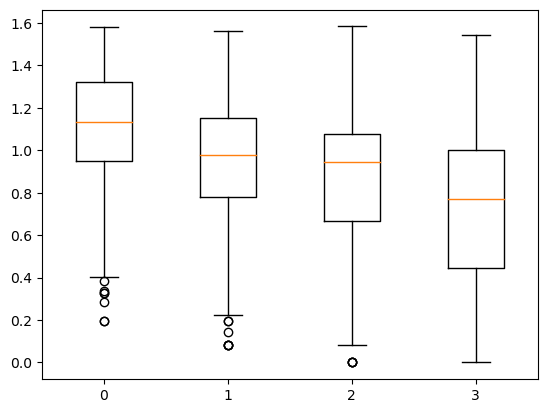

In [93]:
plt.boxplot(x=ents_per_cluster, labels=range(n_clusters))
plt.show()

In [94]:
cluster['label_dist']

1                     [0.22, 0.64, 0.14]
5                     [0.62, 0.25, 0.13]
8                     [0.66, 0.33, 0.01]
12                    [0.92, 0.07, 0.01]
18      [0.8200000000000001, 0.12, 0.06]
                      ...               
2470                  [0.61, 0.28, 0.11]
2475                   [0.04, 0.96, 0.0]
2477                   [0.66, 0.34, 0.0]
2478                   [0.12, 0.68, 0.2]
2486                  [0.66, 0.25, 0.09]
Name: label_dist, Length: 771, dtype: object

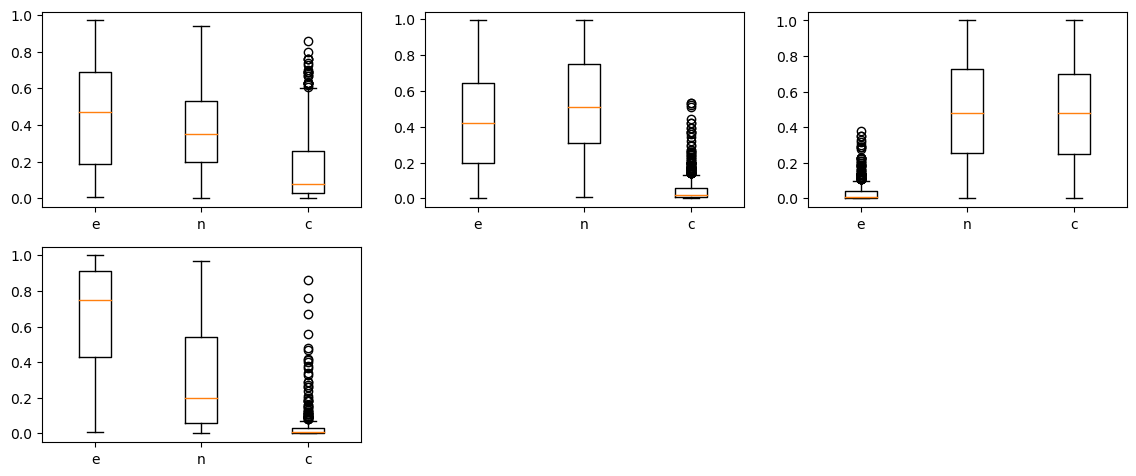

In [95]:
plt.figure(figsize=(14, 30))
for c in range(n_clusters):
    cluster = data[data['k_mean'] == c]
    es = [x[0] for x in cluster['label_dist']]
    ns = [x[1] for x in cluster['label_dist']]
    cs = [x[2] for x in cluster['label_dist']]
    
    plt.subplot(10, 3, c+1)
    plt.boxplot(x=[es, ns, cs], labels=['e', 'n', 'c'])

plt.show()

In [112]:
a, b = model.encode(['This is a sentence.', 'What on earth are you doing?'])

In [114]:
cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [115]:
cos_sim

0.18786618

In [72]:
embed_concat = np.concatenate((p_embedding, h_embedding, np.abs(p_embedding-h_embedding)), axis=1)
embed_concat.shape

(2490, 2304)

[Text(0.5, 1.0, 'Iris data T-SNE projection')]

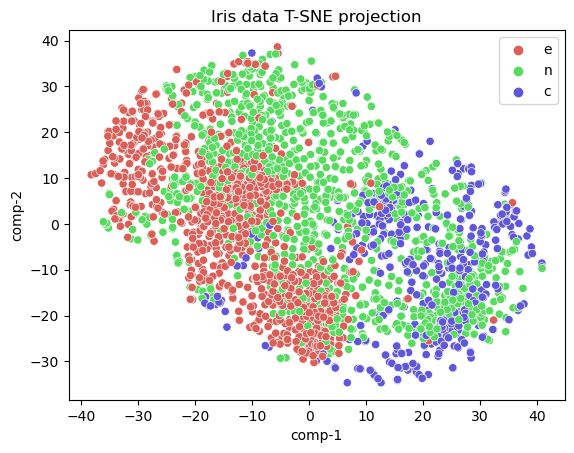

In [76]:
tsne_module = TSNE(n_components=2, random_state=20, perplexity=50, init='random', learning_rate='auto')
transformed_emb = tsne_module.fit_transform(embed_concat)
df = pd.DataFrame()
df["y"] = list(data['majority_label'])
df["comp-1"] = transformed_emb[:,0]
df["comp-2"] = transformed_emb[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Iris data T-SNE projection") 